In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/My Drive/Plate_examples" "/content/"
!cp -r "/content/drive/My Drive/Files" "/content/"
!cp -r "/content/drive/My Drive/Files/local_utils.py" "/content/"

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
import glob

In [ ]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [ ]:
wpod_net_path = "Files/wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [ ]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

Found 11 images...


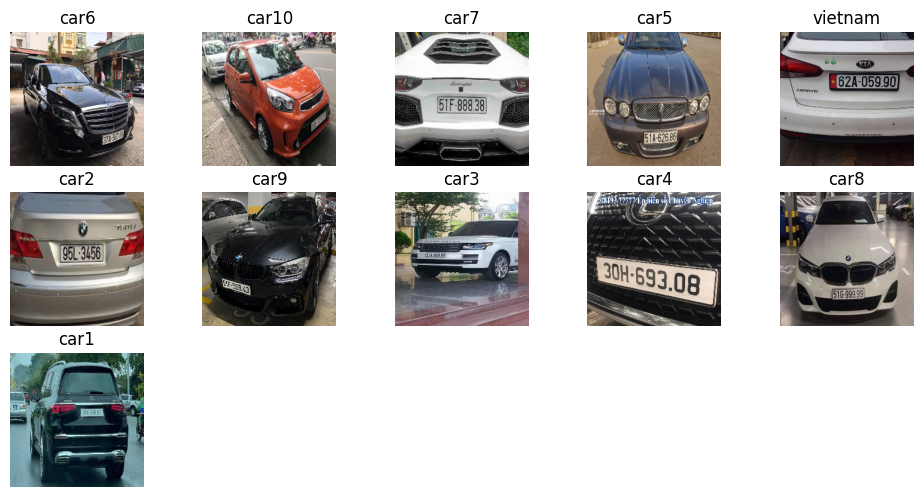

In [ ]:
image_paths = glob.glob("Plate_examples/*.jpg")
print("Found %i images..."%(len(image_paths)))

fig = plt.figure(figsize=(12, 8))
cols = 5
rows = 4
fig_list = []
for i in range(min(cols * rows, len(image_paths))):
    fig_list.append(fig.add_subplot(rows, cols, i + 1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    img = preprocess_image(image_paths[i], True)
    plt.axis(False)
    plt.imshow(img)

plt.show()

1/1 [==============================] - 1s 1s/step
Phát hiện 2 biển số trong car6
Tọa độ của biển số trong hình ảnh: 
 [array([[707.91275824, 872.75235893, 868.32074069, 703.48114   ],
       [596.29229896, 550.42701742, 607.53145412, 653.39673566],
       [  1.        ,   1.        ,   1.        ,   1.        ]]), array([[514.02058712, 570.01079299, 568.32224359, 512.33203772],
       [ 22.87844992,   6.69916227,  85.44858799, 101.62787564],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


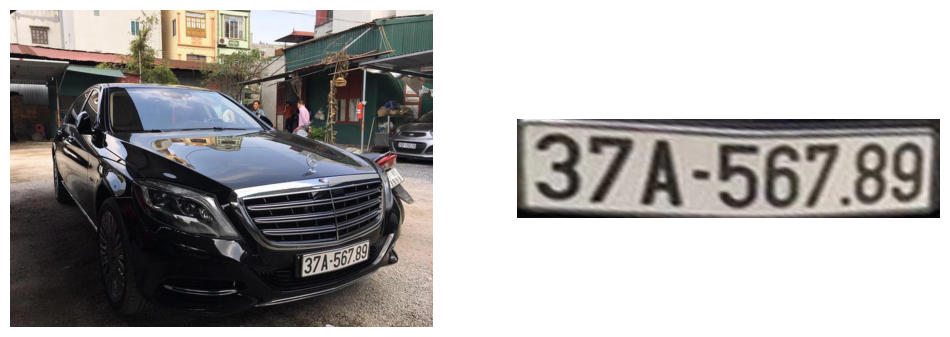

In [ ]:
# Chuyển tiếp hình ảnh qua mô hình và trả về hình ảnh biển số và tọa độ
def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

# Lấy hình ảnh biển số và tọa độ từ một hình ảnh
test_image = image_paths[0]
LpImg, cor = get_plate(test_image)
print("Phát hiện %i biển số trong"%len(LpImg), splitext(basename(test_image))[0])
print("Tọa độ của biển số trong hình ảnh: \n", cor)

# Hiển thị kết quả
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

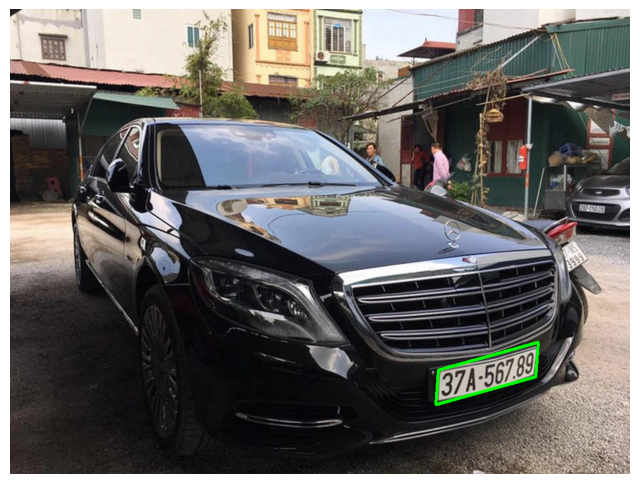

In [ ]:
def draw_box(image_path, cor, thickness=3):
    pts=[]
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]

    # lưu trữ các điểm top-left, top-right, bottom-left, bottom-right của biển số xe tương ứng
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])

    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = preprocess_image(image_path)

    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

plt.figure(figsize=(8,8))
plt.axis(False)
plt.imshow(draw_box(test_image,cor))

1/1 [==============================] - 0s 407ms/step


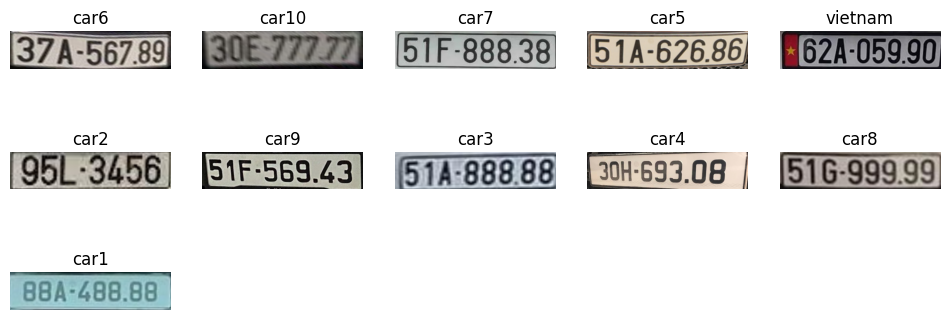

In [ ]:
# Hiển thị tất cả các hình ảnh biển số đã nhận được
fig = plt.figure(figsize=(12, 6))
cols = 5
rows = 4
fig_list = []

for i in range(min(cols * rows, len(image_paths))):
    fig_list.append(fig.add_subplot(rows, cols, i + 1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)

    # Lấy hình ảnh biển số xe
    LpImg, plate_found = get_plate(image_paths[i])

    if plate_found:
        plt.axis(False)
        plt.imshow(LpImg[0])
    else:
        plt.axis(False)
        plt.text(0.5, 0.5, "No License Plate", fontsize=10, ha='center', va='center', color='red')


plt.show()
